# Melbourne Housing Price Prediction Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Melbourne Housing Analysis

This notebook performs exploratory data analysis on the Melbourne housing dataset.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load dataset (update path if needed)
df = pd.read_csv("melb_data.csv")

df.head()


FileNotFoundError: [Errno 2] No such file or directory: 'melb_data.csv'

## 1. Price Distribution

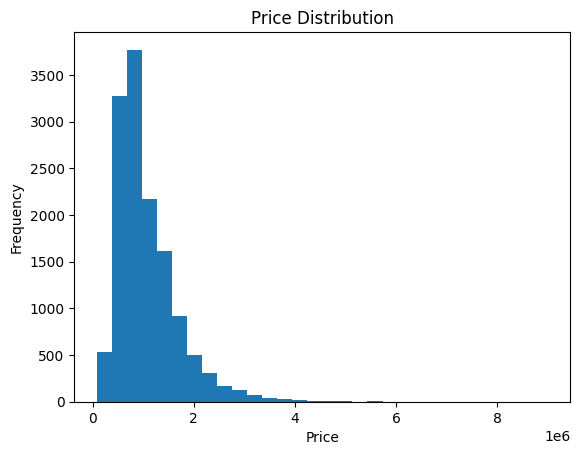

In [ ]:
plt.figure()
plt.hist(df['Price'].dropna(), bins=30)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()


The price distribution is right-skewed, with most properties concentrated at lower prices.

## 2. Price by Property Type

<Figure size 640x480 with 0 Axes>

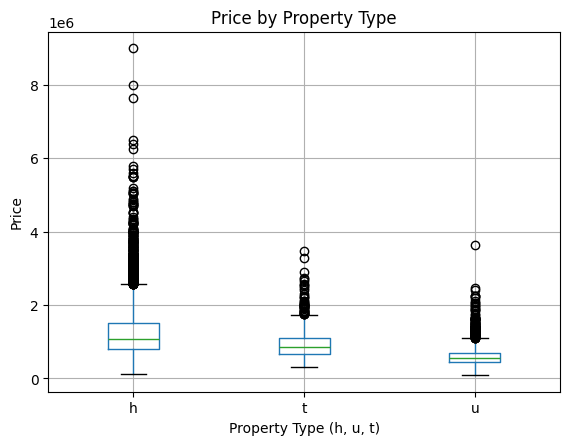

In [ ]:
plt.figure()
df.boxplot(column='Price', by='Type')
plt.xlabel('Property Type (h, u, t)')
plt.ylabel('Price')
plt.title('Price by Property Type')
plt.suptitle('')
plt.show()


## 3. Top 10 Suburbs by Sales

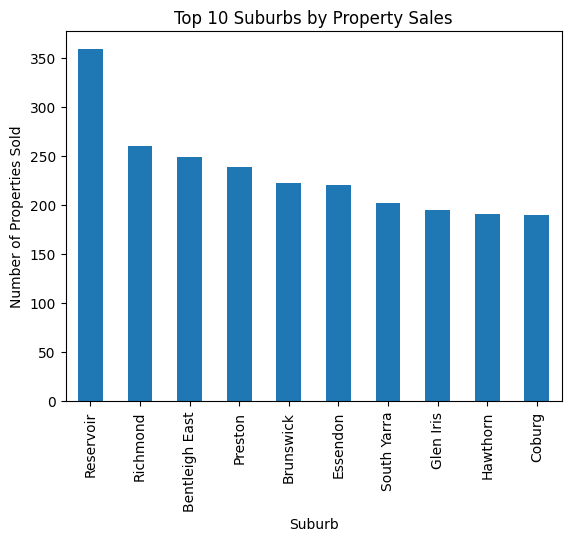

In [ ]:
top_suburbs = df['Suburb'].value_counts().head(10)

plt.figure()
top_suburbs.plot(kind='bar')
plt.xlabel('Suburb')
plt.ylabel('Number of Properties Sold')
plt.title('Top 10 Suburbs by Property Sales')
plt.show()


## 4. Rooms vs Price

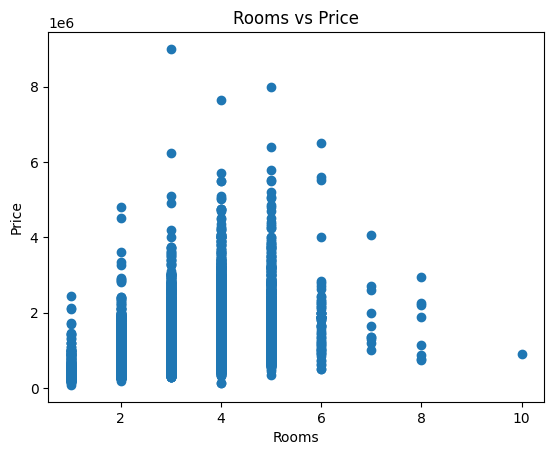

Pearson correlation (Rooms vs Price): 0.497


In [ ]:
rooms_price = df[['Rooms', 'Price']].dropna()

plt.figure()
plt.scatter(rooms_price['Rooms'], rooms_price['Price'])
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.title('Rooms vs Price')
plt.show()

corr_rooms_price, _ = pearsonr(rooms_price['Rooms'], rooms_price['Price'])
print(f"Pearson correlation (Rooms vs Price): {corr_rooms_price:.3f}")


## 5. Distance vs Price

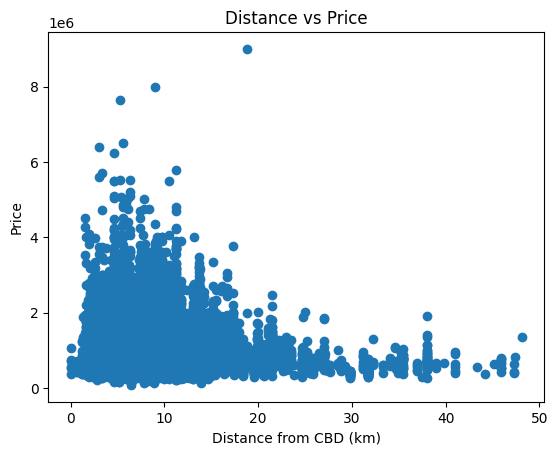

Pearson correlation (Distance vs Price): -0.163


In [ ]:
distance_price = df[['Distance', 'Price']].dropna()

plt.figure()
plt.scatter(distance_price['Distance'], distance_price['Price'])
plt.xlabel('Distance from CBD (km)')
plt.ylabel('Price')
plt.title('Distance vs Price')
plt.show()

corr_distance_price, _ = pearsonr(distance_price['Distance'], distance_price['Price'])
print(f"Pearson correlation (Distance vs Price): {corr_distance_price:.3f}")


This notebook implements a machine learning pipeline to predict house prices in Melbourne using the provided dataset.

## 1. Setup and Imports

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
import joblib


## 2. Load Data

In [ ]:
# =========================
# Load data
# =========================
# NOTE: Assuming 'melb_data.csv' is in the same directory or accessible via the path.
df = pd.read_csv("melb_data.csv")
print(f"Original dataset shape: {df.shape}")
print(df.head())


Original dataset shape: (13580, 21)
       Suburb           Address  Rooms Type      Price Method SellerG  \
0  Abbotsford      85 Turner St      2    h  1480000.0      S  Biggin   
1  Abbotsford   25 Bloomburg St      2    h  1035000.0      S  Biggin   
2  Abbotsford      5 Charles St      3    h  1465000.0     SP  Biggin   
3  Abbotsford  40 Federation La      3    h   850000.0     PI  Biggin   
4  Abbotsford       55a Park St      4    h  1600000.0     VB  Nelson   

        Date  Distance  Postcode  ...  Bathroom  Car  Landsize  BuildingArea  \
0  3/12/2016       2.5    3067.0  ...       1.0  1.0     202.0           NaN   
1  4/02/2016       2.5    3067.0  ...       1.0  0.0     156.0          79.0   
2  4/03/2017       2.5    3067.0  ...       2.0  0.0     134.0         150.0   
3  4/03/2017       2.5    3067.0  ...       2.0  1.0      94.0           NaN   
4  4/06/2016       2.5    3067.0  ...       1.0  2.0     120.0         142.0   

   YearBuilt  CouncilArea Lattitude  Longtit

## 3. Data Cleaning and Feature Engineering

In [ ]:
# =========================
# Checking Outliers
# =========================
col_list = df.columns.tolist()

part1 = col_list[2:3]
part2 = col_list[4:5]
part3 = col_list[8:9]
part4 = col_list[10:15]
part5 = col_list[17:19]
part6= col_list[20:]

numeric_lst = part1 + part2 + part3 + part4 + part5 + part6

def IQR(df, name, pr):

    for col in name:
        df[col] = df[col].astype(float)
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)

        iqr = q3 - q1

        upper_bound = q3 + (1.5 * iqr)
        lower_bound = q1 - (1.5 * iqr)

        count = 0

        for row in range(df[col].shape[0]):
            if df.loc[row, col] < lower_bound:
                df.loc[row, col] = lower_bound
                count += 1
            elif df.loc[row, col] > upper_bound:
                df.loc[row, col] = upper_bound
                count += 1
            else:
                continue
        if pr:
            print(f"The column <{col}> has {count} Outliers !")
    if pr:
        print("\nThe values are now withing the IQR Range !\n")
    return df
df = IQR(df, numeric_lst, pr = True)

The column <Rooms> has 682 Outliers !
The column <Price> has 612 Outliers !
The column <Distance> has 411 Outliers !
The column <Bedroom2> has 655 Outliers !
The column <Bathroom> has 143 Outliers !
The column <Car> has 644 Outliers !
The column <Landsize> has 368 Outliers !
The column <BuildingArea> has 353 Outliers !
The column <Lattitude> has 262 Outliers !
The column <Longtitude> has 408 Outliers !
The column <Propertycount> has 359 Outliers !

The values are now withing the IQR Range !



In [ ]:
# Double check for outliers

df = IQR(df, numeric_lst, pr = True)

The column <Rooms> has 0 Outliers !
The column <Price> has 0 Outliers !
The column <Distance> has 0 Outliers !
The column <Bedroom2> has 0 Outliers !
The column <Bathroom> has 0 Outliers !
The column <Car> has 0 Outliers !
The column <Landsize> has 0 Outliers !
The column <BuildingArea> has 0 Outliers !
The column <Lattitude> has 0 Outliers !
The column <Longtitude> has 0 Outliers !
The column <Propertycount> has 0 Outliers !

The values are now withing the IQR Range !



In [ ]:
def IQR_by_type(df, col, types=('t', 'u')):

    df = df.copy()

    for t in types:
        mask = df['Type'] == t
        Q1, Q3 = df.loc[mask, col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        df.loc[mask, col] = df.loc[mask, col].clip(Q1 - 1.5*IQR, Q3 + 1.5*IQR)

    return df
df = IQR_by_type(df, col='Price')

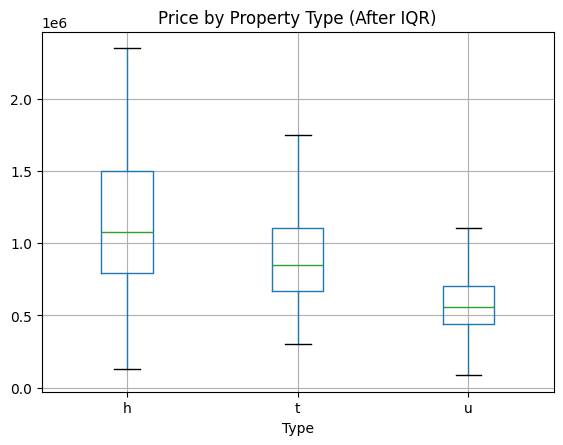

In [ ]:
df.boxplot(column='Price',by='Type')
plt.title('Price by Property Type (After IQR)')
plt.suptitle('')
plt.show()

In [ ]:
# =========================
# Cleaning
# =========================
# Drop rows without target
df = df.dropna(subset=["Price"]).copy()
print(f"Shape after dropping rows with missing Price: {df.shape}")

# Convert Date
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df["SaleYear"] = df["Date"].dt.year
df["SaleMonth"] = df["Date"].dt.month

# Drop high-cardinality / useless columns
df.drop(columns=["Date", "Address"], inplace=True)
print("Dropped 'Date' and 'Address' columns.")


Shape after dropping rows with missing Price: (13580, 21)
Dropped 'Date' and 'Address' columns.


## 4. Split Features and Target

In [ ]:
# =========================
# Split features / target
# =========================
X = df.drop("Price", axis=1)
y = df["Price"]

num_cols = X.select_dtypes(include=["number"]).columns
cat_cols = X.select_dtypes(exclude=["number"]).columns

print(f"Numerical features: {list(num_cols)}")
print(f"Categorical features: {list(cat_cols)}")


Numerical features: ['Rooms', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount', 'SaleYear', 'SaleMonth']
Categorical features: ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']


## 5. Preprocessing Pipeline (Imputation and Encoding)

In [ ]:
# =========================
# Preprocessing
# =========================
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

print("Preprocessing pipelines defined.")


Preprocessing pipelines defined.


## 6. Train / Test Split

In [ ]:
# =========================
# Train / Test split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (10864, 20)
X_test shape: (2716, 20)


## 7. Model Definition

In [ ]:
# =========================
# Model
# =========================
model = HistGradientBoostingRegressor(
    max_depth=8,
    learning_rate=0.05,
    max_iter=400,
    random_state=42
)

pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", model)
])

print("Full ML pipeline defined.")


Full ML pipeline defined.


## 8. Train Model

In [ ]:
# =========================
# Train
# =========================
print("Starting model training...")
pipeline.fit(X_train, y_train)
print("Model training complete.")


Starting model training...
Model training complete.


## 9. Evaluate Model

In [ ]:
# =========================
# Evaluate
# =========================
preds = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("Model Performance on Test Set")
print(f"MAE  : {mae:,.0f}")
print(f"RMSE : {rmse:,.0f}")
print(f"R²   : {r2:.3f}")


Model Performance on Test Set
MAE  : 126,535
RMSE : 182,001
R²   : 0.879


## 10. Save Outputs

In [ ]:
# =========================
# Save outputs
# =========================
# Save the cleaned data (optional, for inspection)
df.to_csv("melb_data_cleaned.csv", index=False)

# Save the trained model pipeline
joblib.dump(pipeline, "melb_price_model.pkl")

print("Cleaned data and trained model saved to disk.")


Cleaned data and trained model saved to disk.
